# EDA MESSIDOR MACULAR EDEMA

In [17]:
%matplotlib inline

from shutil import copy, move, rmtree, unpack_archive
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import os
import progressbar

## Getting Data

In [18]:
MESSIDOR_PATH = "Data/BD1"

In [19]:
DB_PATH = 'DB'
if os.path.exists(DB_PATH):
    rmtree(DB_PATH)
os.mkdir(DB_PATH)

In [20]:
def unzip_set(i:int, zipFile: str, outputPath: str = DB_PATH):
    print(f'{i}-{zipFile}')
    zipFile = os.path.sep.join([MESSIDOR_PATH, zipFile])
    unpack_archive(zipFile, outputPath)

In [21]:
zipfiles = [z for z in os.listdir(MESSIDOR_PATH) if '.zip' in z]

for i, zf in enumerate(zipfiles):
    unzip_set(i=i+1,zipFile=zf)

1-Base21.zip
2-Base12.zip
3-Base24.zip
4-Base23.zip
5-Base31.zip
6-Base14.zip
7-Base32.zip
8-Base34.zip
9-Base11.zip
10-Base13.zip
11-Base22.zip
12-Base33.zip


In [22]:
folders = ['DB/Base11', 'DB/Base13']

for f in folders:
    try:
        image_paths = os.listdir(f)
        image_paths = [os.path.sep.join([f, img]) for img in image_paths]
        
        [move(img, DB_PATH) for img in image_paths]
        if os.path.exists(f):
            rmtree(f)
    except FileNotFoundError:
        print("Files were already dealt with")
        break
    else:
        print(f"{f} contents have been moved to {DB_PATH}")

DB/Base11 contents have been moved to DB
DB/Base13 contents have been moved to DB


In [23]:
excel_files = [f for f in os.listdir(DB_PATH) if '.xls' in f]
dataframes = []

for xls_file in excel_files:
    path = os.path.sep.join([DB_PATH, xls_file])
    tmp_df = pd.read_excel(path)
    
    dataframes.append(tmp_df)

orig_dataset = pd.concat(dataframes)
orig_dataset.dropna(inplace=True)
orig_dataset

,Image name,Ophthalmologic department,Retinopathy grade,Risk of macular edema
0,20060411_57879_0200_PP.tif,CHU de St Etienne,3,2
1,20060411_57962_0200_PP.tif,CHU de St Etienne,1,0
2,20060411_57986_0200_PP.tif,CHU de St Etienne,1,0
3,20060411_58051_0200_PP.tif,CHU de St Etienne,1,0
4,20060411_58071_0200_PP.tif,CHU de St Etienne,0,0
...,...,...,...,...
95,20051205_35305_0400_PP.tif,LaTIM - CHU de BREST,3,0
96,20051205_35323_0400_PP.tif,LaTIM - CHU de BREST,3,2
97,20051205_35339_0400_PP.tif,LaTIM - CHU de BREST,3,2
98,20051205_35354_0400_PP.tif,LaTIM - CHU de BREST,3,1


In [24]:
columns = orig_dataset.columns
columns

Index(['Image name', 'Ophthalmologic department', 'Retinopathy grade',
       'Risk of macular edema '],
      dtype='object')

In [25]:
orig_dataset.drop(columns=columns[1:-1], inplace=True)
orig_dataset

,Image name,Risk of macular edema
0,20060411_57879_0200_PP.tif,2
1,20060411_57962_0200_PP.tif,0
2,20060411_57986_0200_PP.tif,0
3,20060411_58051_0200_PP.tif,0
4,20060411_58071_0200_PP.tif,0
...,...,...
95,20051205_35305_0400_PP.tif,0
96,20051205_35323_0400_PP.tif,2
97,20051205_35339_0400_PP.tif,2
98,20051205_35354_0400_PP.tif,1


In [26]:
orig_dataset.rename(
    columns={
        "Image name": "image",
        "Risk of macular edema ": "ME_Risk"
    },
    errors="raise",
    inplace=True
    )
orig_dataset

,image,ME_Risk
0,20060411_57879_0200_PP.tif,2
1,20060411_57962_0200_PP.tif,0
2,20060411_57986_0200_PP.tif,0
3,20060411_58051_0200_PP.tif,0
4,20060411_58071_0200_PP.tif,0
...,...,...
95,20051205_35305_0400_PP.tif,0
96,20051205_35323_0400_PP.tif,2
97,20051205_35339_0400_PP.tif,2
98,20051205_35354_0400_PP.tif,1


ME_Risk
0    974
1     75
2    151
Name: image, dtype: int64

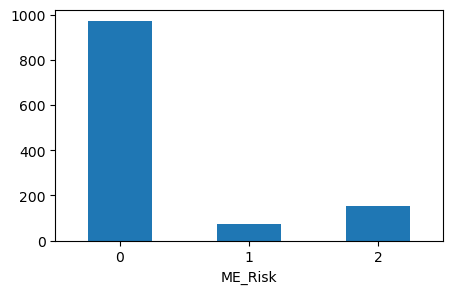

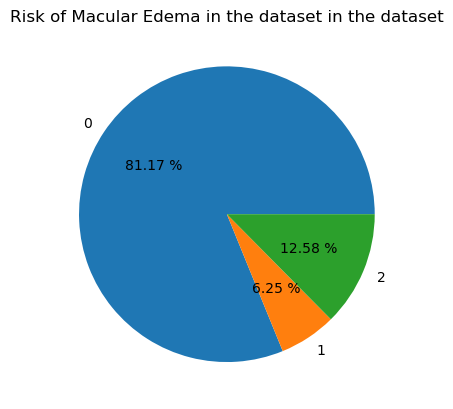

In [27]:
display(orig_dataset.groupby('ME_Risk')['image'].count())

dfp = orig_dataset.pivot_table(
    index='ME_Risk',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 3
plt.pie([orig_dataset.loc[orig_dataset['ME_Risk'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Risk of Macular Edema in the dataset in the dataset")
# img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
# plt.savefig(img_path)
plt.show()

In [28]:
dataset = orig_dataset.groupby(['ME_Risk']).sample(60)
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['ME_Risk'],
    train_size=0.7,
    test_size=0.3,
    random_state=42
)

rest_df = orig_dataset.loc[~orig_dataset['image'].isin(dataset['image'])].dropna()

display(rest_df.groupby('ME_Risk')['image'].count())

ME_Risk
0    914
1     15
2     91
Name: image, dtype: int64

In [29]:
train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['ME_Risk'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['ME_Risk'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['ME_Risk'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['ME_Risk'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['ME_Risk'] = y_test

ME_Risk
0    42
1    42
2    41
Name: image, dtype: int64

ME_Risk
0    11
1     7
2     9
Name: image, dtype: int64

ME_Risk
0     7
1    10
2    10
Name: image, dtype: int64

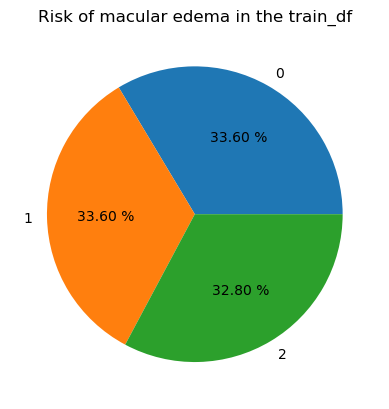

In [30]:
display(train_df.groupby(['ME_Risk'])['image'].count())
display(val_df.groupby(['ME_Risk'])['image'].count())
display(test_df.groupby(['ME_Risk'])['image'].count())
plt.pie([train_df.loc[train_df['ME_Risk'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Risk of macular edema in the train_df")
plt.show()
# train_df.head()

In [31]:
def create_path(base_dir:str, dir_name:str):
    directory = os.path.sep.join([base_dir, dir_name])
    """
    Creates a new directory if it doesn't exist already

    - dir_name: path to directory
    """
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print(f'[INFO] {directory} already exists')
    
    return directory

def display_df_dist(df: pd.DataFrame, df_name:str):
    dfp = df.pivot_table(
        index='ME_Risk',
        aggfunc='size'
    )
    dfp.plot(
        kind='bar',
        figsize=(5,3),
        rot=0
    )
    plt.title(f"Risk of Macular Edema in the {df_name} dataset")
    plt.savefig(os.path.sep.join(['DB', f'{df_name}.png']))
    plt.show()
    df.head()

def organize_set_imgs(df: pd.DataFrame, set_path:str):

    # images divided by class dir
    class_directories = {str(k):list(df['image'].loc[df['ME_Risk'] == k]) for k in range(classes)}
    # display(class_directories)

    for k,imgs in class_directories.items():
        class_dir = create_path(set_path, k)

        widgets = [
            f'Building {set_path.split(os.path.sep)[-1]}/{k}:',
            ' ',
            progressbar.Percentage(),
            ' ',
            progressbar.Bar(),
            ' ',
            progressbar.Counter()
        ]

        pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(imgs))
        
        pbar.start()

        non_existent_imgs = 0

        for i, img in enumerate(imgs):
            im_origin = os.path.sep.join([DB_PATH, f'{img}'])
            
            try:
                move(im_origin, class_dir)
            except FileNotFoundError:
                non_existent_imgs += 1
                continue

            pbar.update(i)
        
    pbar.finish()


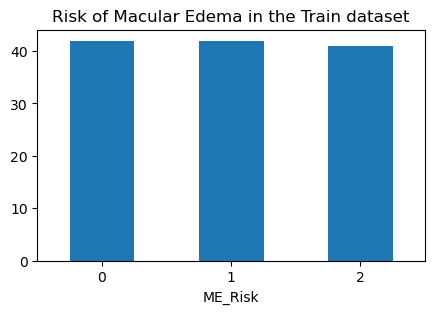

Building Train/2: 100% |###################################################| 41


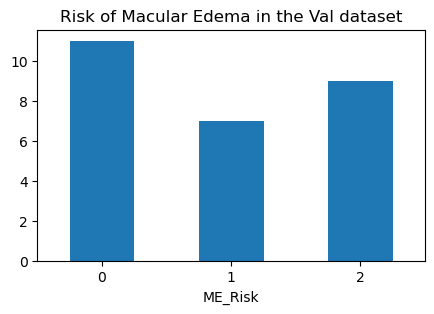

Building Val/2: 100% |######################################################| 9


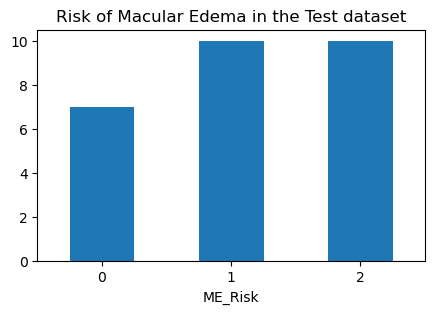

Building Test/2: 100% |####################################################| 10


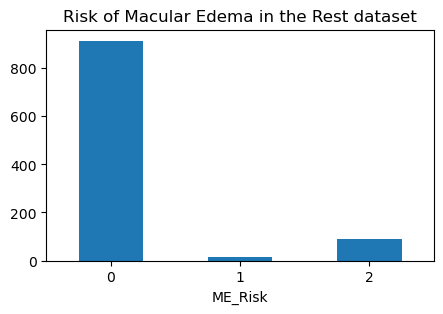

Building Rest/2: 100% |####################################################| 91


In [32]:
data = [
    (train_df, 'Train'),
    (val_df, 'Val'),
    (test_df, 'Test'),
    (rest_df, 'Rest'),
]

for df, subset in data:
    ds_path = create_path(DB_PATH, subset)
    display_df_dist(df, subset)
    organize_set_imgs(df, ds_path)